# i. Business Understanding

## i.i Blocker Fraud Company

* The Blocker Fraud Company is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with no guarantee of blocking fraudulent transactions.

* And the business model of the company is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

### i.i.i Expansion Problem

Blocker Fraud Company is expanding and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:
1. The company will receive 25% of the value of each transaction that is truly detected as fraud. 
1. The company will receive 5% of the value of each transaction detected as fraud, but the transaction is truly legitimate.
1. The company will return 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.

## i.ii The Challenge

You need to deliver to the CEO of Blocker Fraud Company a production model in which your access will be done via API, that is, customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

### i.ii.i Business Questions

1. What is the model's Precision and Accuracy?
1. How Reliable is the model in classifying transactions as legitimate or fraudulent?
1. What is the Expected Billing by the Company if we classify 100% of transactions with the model?
1. What is the Loss Expected by the Company in case of model failure?
1. What is the Profit Expected by the Blocker Fraud Company when using the model?

In [1]:
import joblib # to save models
import warnings
import inflection # string transformation

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats

from sklearn.decomposition import PCA

from IPython.display      import Image
from IPython.core.display import HTML 

# classification ie fraud / legit
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# metrrics
from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score # used for agreement between 2  classfier for prediction 
                                                                                           # observed - expected class / 1 - expected class
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [4]:
# like a covariance or corelation but for categorical vars
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values # pivot table
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [5]:

def ml_cv_results(model_name, model, x, y, verbose=1):
    ''' Cross-validation with stratified k-fold '''
    
    # Initialize metric lists
    metrics = {
        "Balanced Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "Kappa": []
    }
    
    # MinMax Scaling
    scaler = MinMaxScaler()
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (index_train, index_test) in enumerate(skf.split(x, y), start=1):
        if verbose > 0:
            print(f'Fold {fold}/{skf.get_n_splits()}')

        # Splitting into train-test for this fold
        x_train, x_test = x[index_train], x[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]  # Ensure correct indexing in Pandas Series
        
        # Apply MinMax Scaling
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # Train model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        # Compute metrics
        metrics["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred))
        metrics["Recall"].append(recall_score(y_test, y_pred))
        metrics["F1"].append(f1_score(y_test, y_pred))
        metrics["Kappa"].append(cohen_kappa_score(y_test, y_pred))

    # Compute mean and standard deviation for each metric
    results = {metric: f"{np.mean(values):.3f} +/- {np.std(values):.3f}" for metric, values in metrics.items()}
    
    # Return results as a DataFrame
    return pd.DataFrame(results, index=[model_name])


In [50]:
def ml_cv_results_df(model_name, model, x, y, verbose=1):
    ''' Cross-validation with stratified k-fold '''
    
    # Initialize metric lists
    metrics = {
        "Balanced Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "Kappa": []
    }
    
    # MinMax Scaling
    scaler = MinMaxScaler()
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (index_train, index_test) in enumerate(skf.split(x, y), start=1):
        if verbose > 0:
            print(f'Fold {fold}/{skf.get_n_splits()}')

        # Splitting into train-test for this fold
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]  # Ensure correct indexing in Pandas Series
        
        # Apply MinMax Scaling
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # Train model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        # Compute metrics
        metrics["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred))
        metrics["Recall"].append(recall_score(y_test, y_pred))
        metrics["F1"].append(f1_score(y_test, y_pred))
        metrics["Kappa"].append(cohen_kappa_score(y_test, y_pred))

    # Compute mean and standard deviation for each metric
    results = {metric: f"{np.mean(values):.3f} +/- {np.std(values):.3f}" for metric, values in metrics.items()}
    
    # Return results as a DataFrame
    return pd.DataFrame(results, index=[model_name])


# Data Description

## Loading Data

In [6]:
df1 = pd.read_csv(r"E:\skill based learning\DATA SCIENCE\git hub Repos\transaction-fraud-detection\data\raw\fraud_0.1origbase.csv")

In [7]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [8]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


In [9]:
df1.shape

(636262, 11)

## Columns

### Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Column Rename

In [10]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [11]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## Data Dimension

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## Data Types and Structure

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## Check NA

In [14]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

##  Fill Out NA

There's no NaN values to fill.

## Change Data Type for analysis purpose

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [15]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## Description Statistics

In [16]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

###  Numerical Attributes

In [17]:
describe = num_attributes.describe().T

# add some more statstical measuers
describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C334643493,C2083562754,no,no
freq,224216,2,14,635441,636260


* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# Feature Engineering

In [19]:
df2 = df1.copy()

##  Mind Map

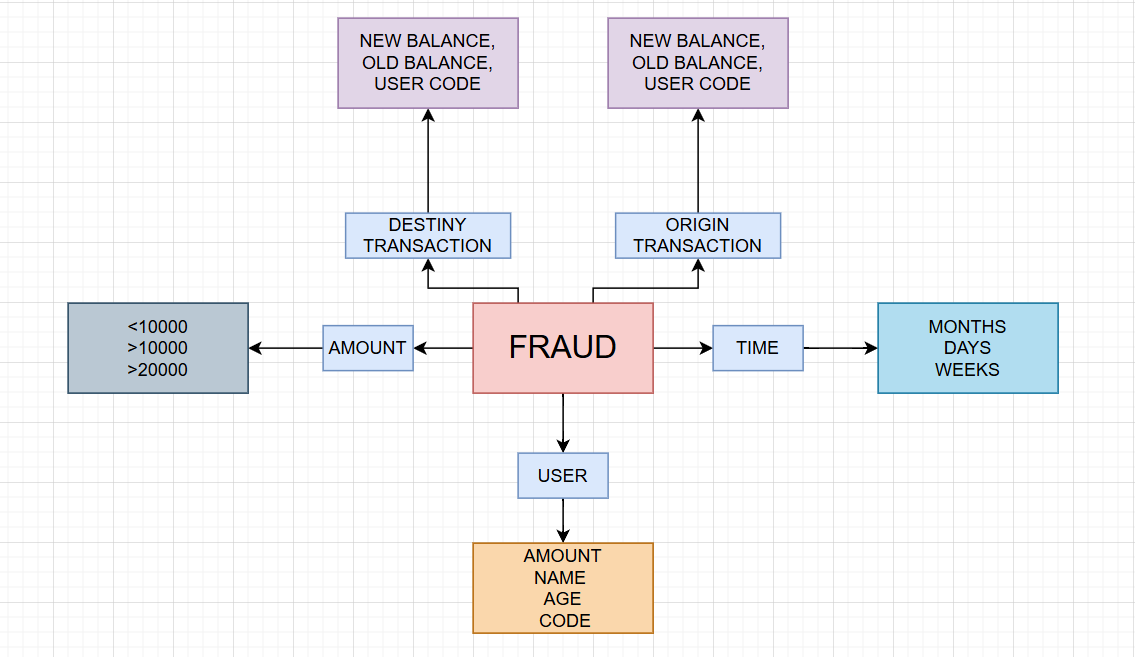

## Hypothesis Creation

### 1. User

1. **The majority of fraud transactions occur for users with the same initial letter.**
- Assumption: Fraudulent users might share certain naming patterns.
- Reasoning: Fraudsters could be using systematically generated or fake names that follow a specific pattern, or there may be cultural or demographic influences affecting name distributions.

2. **The fraud amount is greater than 10,000.**
- Assumption: High-value transactions are more likely to be fraudulent.
- Reasoning: Fraudsters may aim for larger sums to maximize their gains while minimizing the number of fraudulent transactions to avoid detection.

3. **60% of fraudsters are older than 30 years old.**
- Assumption: Age distribution impacts fraud likelihood.
- Reasoning: Older individuals might have better financial access, higher credit limits, or more experience in exploiting financial systems, making them more capable of executing sophisticated fraud schemes.

### 2. Type

1. **Most of fraud transactions occur using the cash-out-type method.**
- Assumption: Fraudsters prefer methods that allow them to quickly withdraw money.
- Reasoning: Cash-out transactions provide immediate access to funds, making it harder to trace and recover fraudulent amounts before they are withdrawn or moved elsewhere.

2. **The majority of transfers occur using the transfer-type method.**
- Assumption: Transfers are the preferred method for moving funds.
- Reasoning: Fraudsters or legitimate users frequently use transfers for sending money between accounts, as it is a common and convenient method for financial transactions.

3. **Values greater than 100,000 occur using the transfer-type method.**
- Assumption: Large financial transactions are more likely to be handled through transfers rather than other methods.
- Reasoning: Transfers allow for high-value transactions in a secure manner, making them the preferred choice for moving large amounts of money. Fraudulent actors may also use transfers to move large sums efficiently.

4. **Payment-type transactions occur with values lower than 100,000.**
- Assumption: Mobile Payments are generally used for smaller transactions.
- Reasoning: Mobile Payments are often associated with retail transactions, bills, and personal expenses, which typically involve lower amounts compared to large-scale transfers.

### 3. Origin and Destiny Transactions

1. **Most % of the difference between origin and destination transactions is equal to 0 for frauds.**
- Assumption: Fraudulent transactions may involve money being moved between accounts without actual changes in balances.  
- Reasoning: Fraudsters might use tactics such as transaction mirroring, where the origin and destination values remain the same, making it harder to detect fraudulent activities. This could indicate account manipulation or automated fraud techniques.  

2. **Origin values are greater than destination values for fraud transactions.** 
- Assumption: Fraudulent transactions often involve siphoning money from an account to another without equivalent compensation.  
- Reasoning:* In fraud cases, the transaction might withdraw a larger amount from the origin account while depositing less or nothing into the destination account, indicating unauthorized fund movement or skimming techniques.  


### 4. Time

**Fraud transactions occur at least in 3 days.**  
- Fraudulent transactions may take time to execute due to risk management and detection systems.  
- Fraudsters might delay transactions to avoid triggering real-time fraud detection mechanisms, making it harder to identify suspicious patterns immediately.  

**40% of the cash-out transactions occur in less than 1 day.**  
- Cash-out transactions are often executed quickly to withdraw stolen funds before detection.  
- Fraudsters prefer quick cash-out methods to minimize the risk of accounts being flagged or frozen by security systems.  

**60% of the transactions less than 100,000 occur in at least 10 days.**  
- Smaller transactions may be spread over time to avoid detection.  
- Fraudsters could attempt to bypass fraud detection by conducting multiple smaller transactions rather than one large transfer.  

**Transactions greater than 10,000 occur at most in 2 weeks.**  
- Large transactions often happen within a short period to reduce exposure to fraud detection.  
- Fraudsters may execute high-value transactions quickly to move funds before authorities or financial institutions flag them.  


## 5. Hypotheses List

1. The majority fraud transiction occours for the same initial letter user.

1. All the fraud amount is greater than 10.000.

1. Most of fraud transaction occours using cash-out-type method.

1. The majority transfers occours using tranfers-type method.

1. Fraud transactions occours at least in 3 days.

##  Feature Engineering

In [20]:
# step, convert the step into weeks or days
# steps is a time variable, each step is 1 hour
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name origin and name destination
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

In [21]:
df3 = df2.copy()

# Exploratory Data Analisys

In [22]:
df4 = df3.copy()

##  Univariate Analysis

### Response Variable

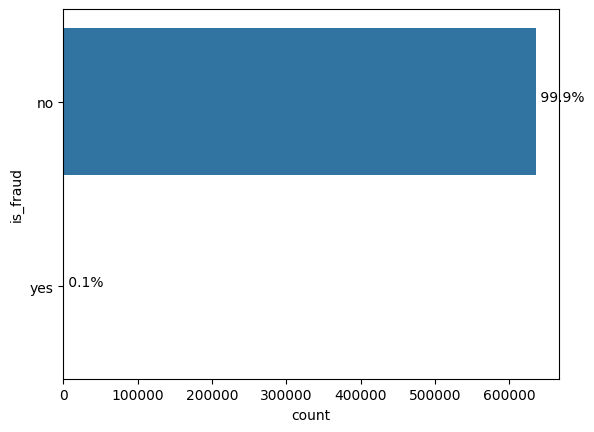

In [23]:
ax = sns.countplot(y='is_fraud', data=df4)

total = df4['is_fraud'].size

# putting text
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

###  Numerical Variables

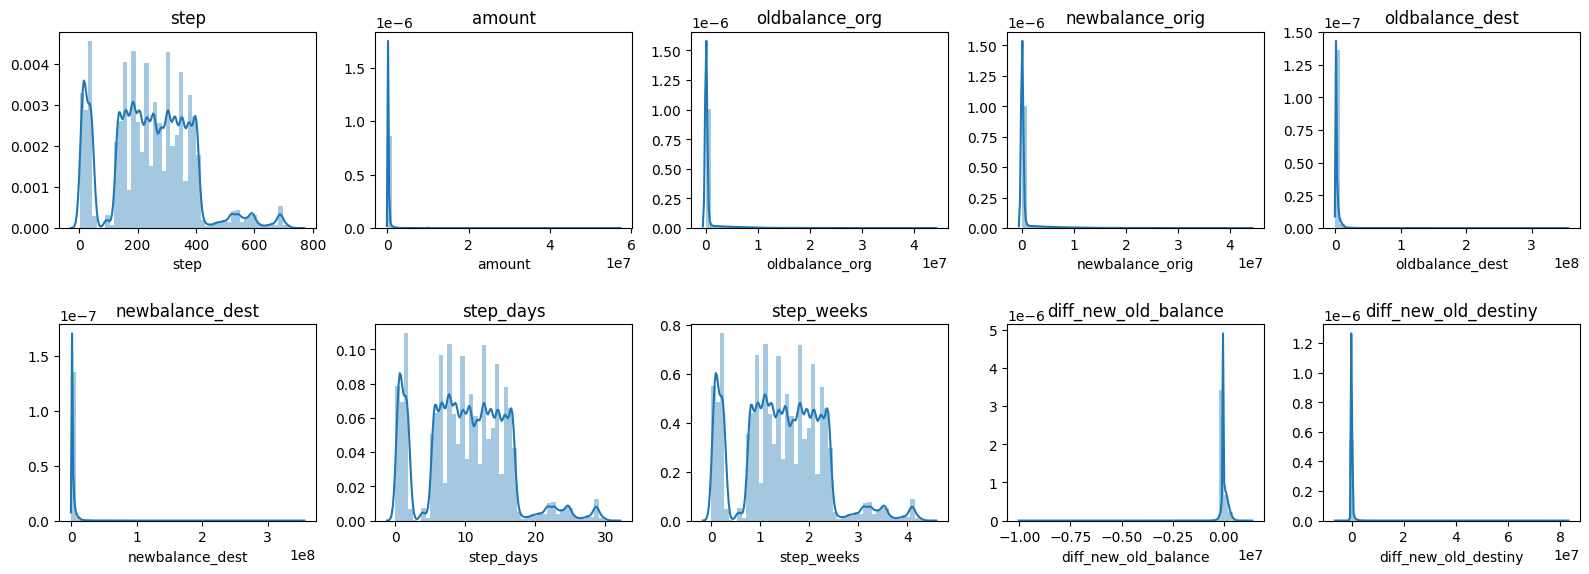

In [24]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1
plt.figure(figsize = (16, 6))

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);
    plt.title(column)
    plt.ylabel('')
    j += 1
    
plt.tight_layout()
plt.show()

### Categorical Variables

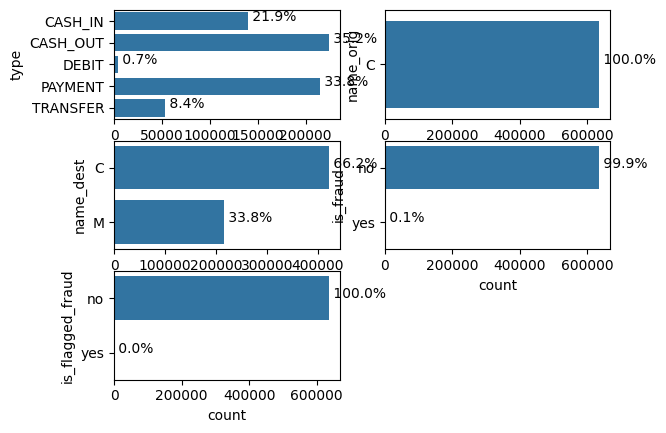

In [25]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

plt.show()

## Bivariate Analysis

### H1 The majority fraud transiction occours for the same user.
**TRUE:** The same user origin and destiny has got the same inital letter.

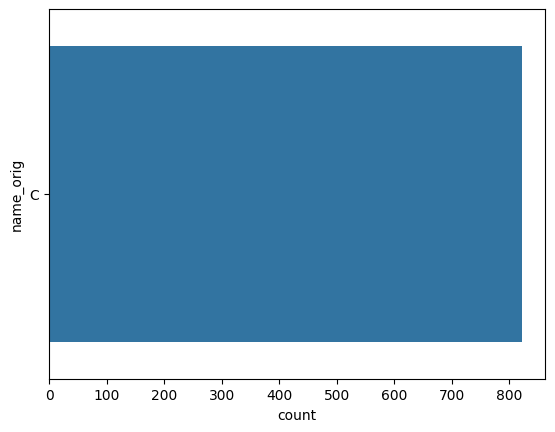

In [26]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1)
plt.show()

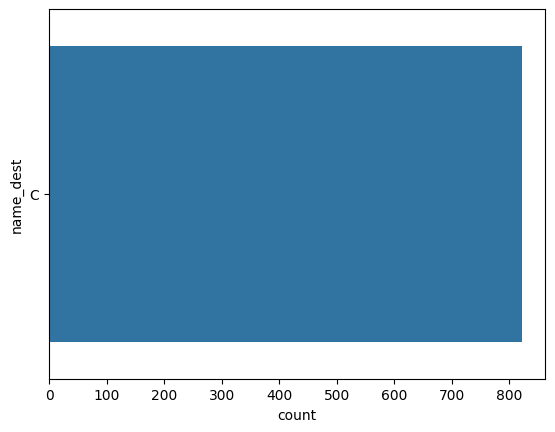

In [27]:
sns.countplot(y='name_dest', data=aux1)
plt.show()

### H2 All the fraud amount is greater than 10.000.

**TRUE:** The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

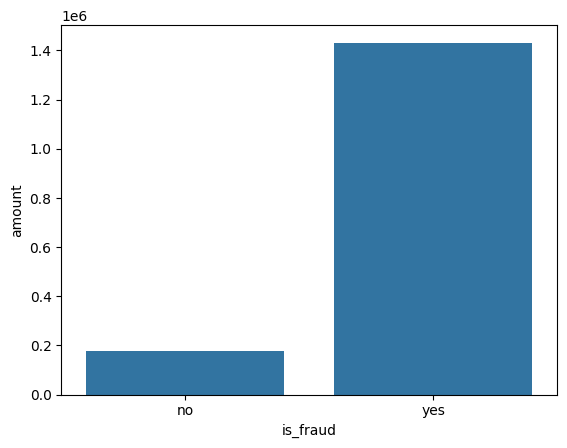

In [28]:
sns.barplot(df4.groupby('is_fraud').amount.mean())
plt.show()

### H3 60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

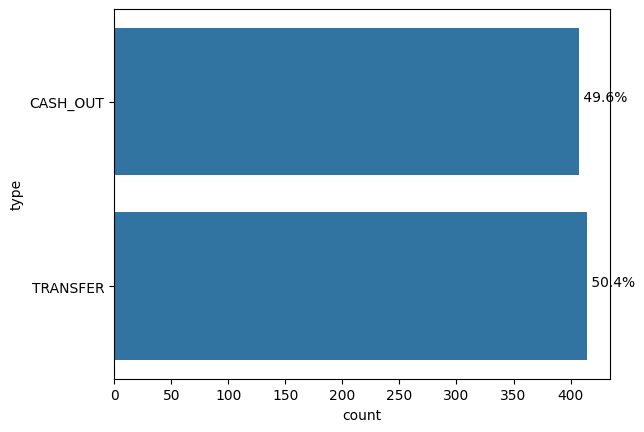

In [29]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

To see the complete transiction-type and I'll plot them here.

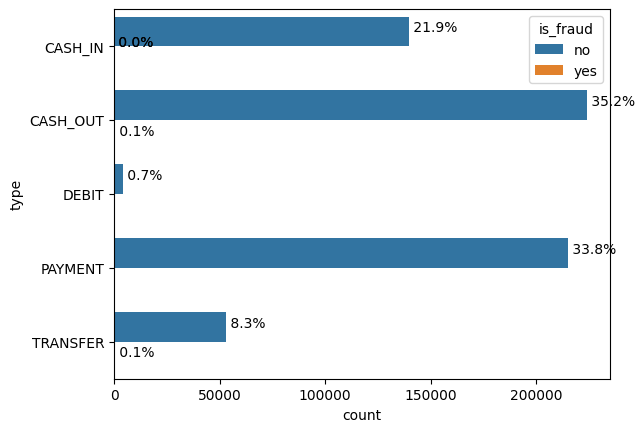

In [30]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


plt.show()

### H4 Values greater than 100.000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

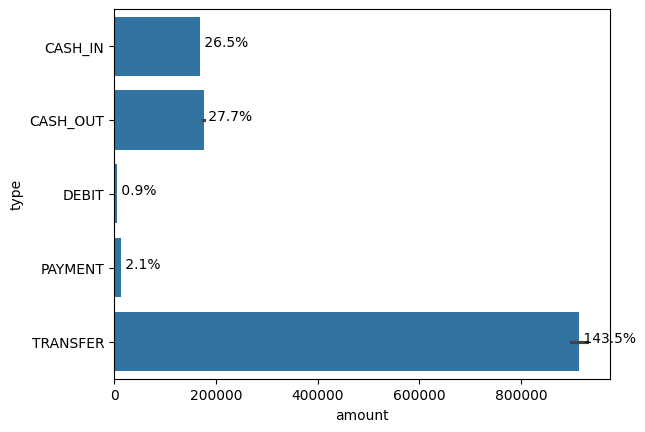

In [31]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

### H5 Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

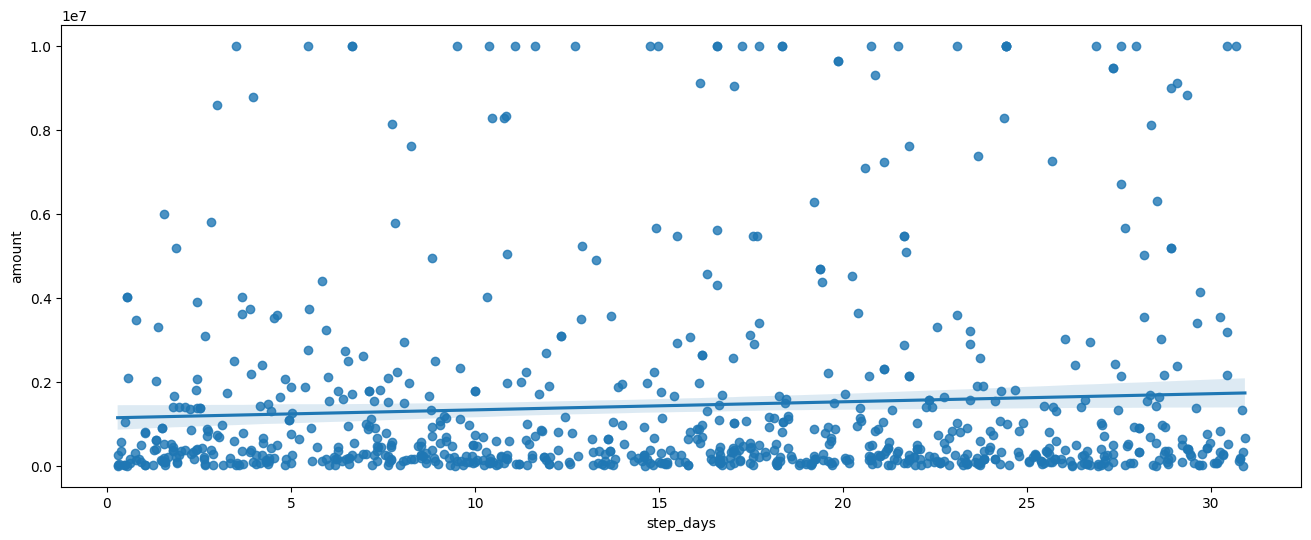

In [32]:
plt.figure(figsize= (16,6))
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1)
plt.show()

## Multivariate Analysis

### Numerical Analysis

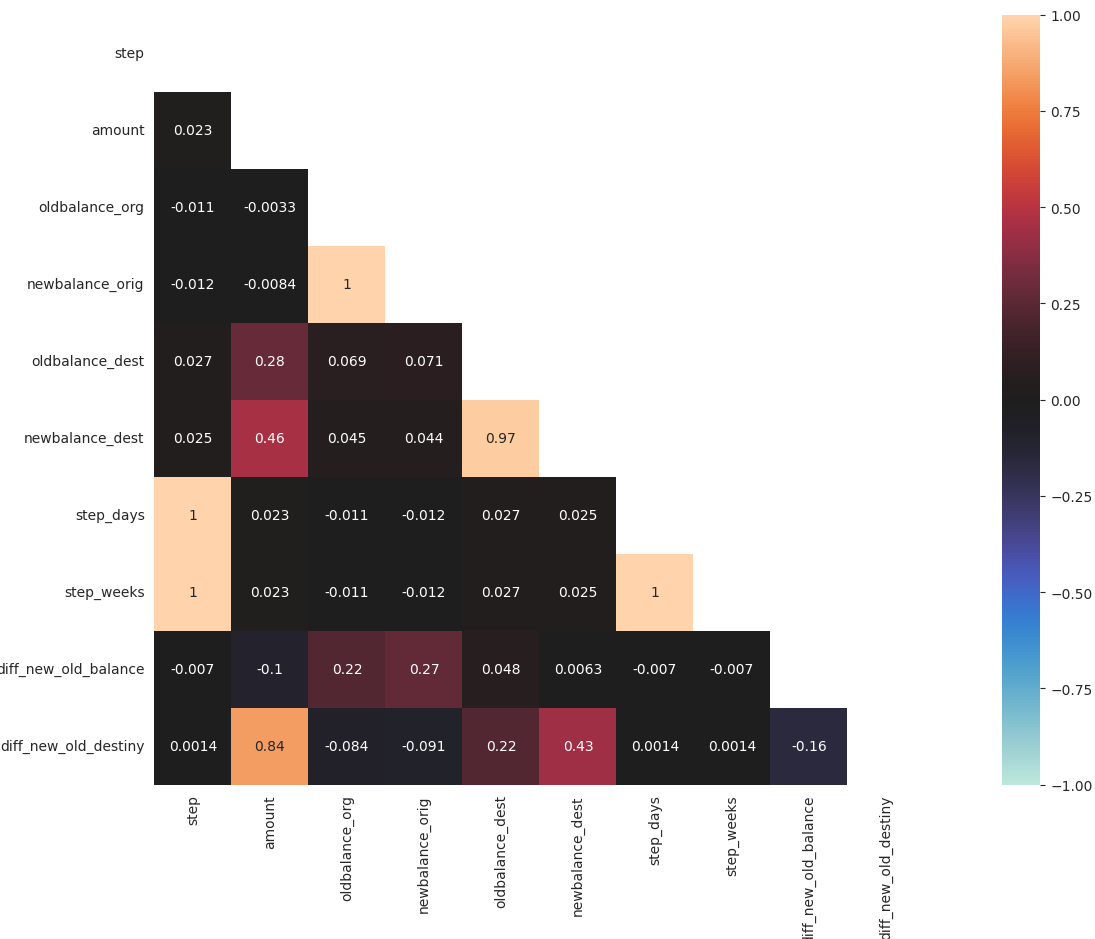

In [33]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize= (20,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)
plt.show()

### 4.3.2 Categorical Variables

In [34]:
cat_attributes = df4.select_dtypes(include = "object")

In [35]:
# compute cramers v for all categorical vars
dict_corr = {}
cat_attributes = cat_attributes.dropna()  
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

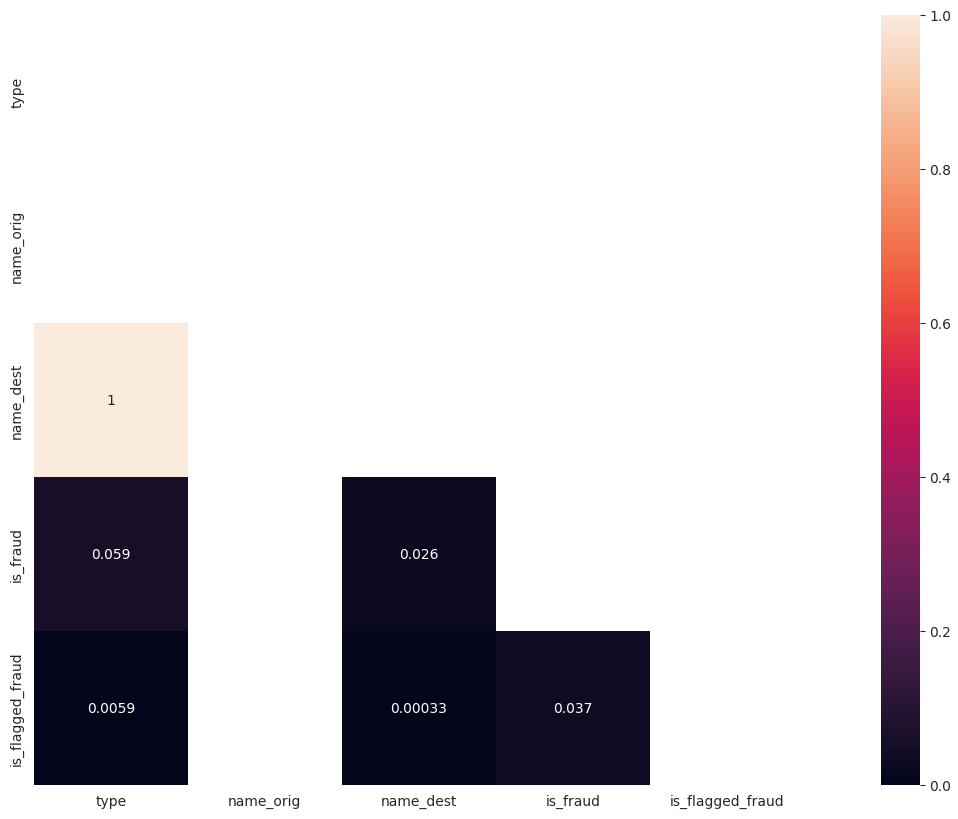

In [36]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize= (20,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

plt.show()

# Data Preparation

In [37]:
df5 = df4.copy()

## Spliting into Train, Valid and Test

In [38]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [39]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y) 
# stratified sampling to ensure same classdistribuion in both train test

In [40]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## One Hot Encoder

In [41]:
X.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,210329.85,-210329.84
1,132,CASH_OUT,215489.19,21518.00,0.00,6345756.55,6794954.89,-21518.00,449198.34
2,355,DEBIT,4431.05,20674.00,16242.95,80876.56,85307.61,-4431.05,4431.05
3,135,CASH_OUT,214026.20,46909.73,0.00,13467450.36,13681476.56,-46909.73,214026.20
4,381,CASH_OUT,8858.45,0.00,0.00,1667180.58,1676039.03,0.00,8858.45


In [42]:

# one hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_temp = pd.get_dummies(X_temp)
X_valid = pd.get_dummies(X_valid)

## Rescaling

In [43]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']

mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [44]:
X_train.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
418833,304,0.000463,0.000013,0.000707,0.001891,0.001815,0.881133,0.069490,True,False,False,False,False
535343,448,0.006304,0.000000,0.000000,0.003725,0.004738,0.878805,0.073839,False,True,False,False,False
419647,129,0.019494,0.000000,0.000000,0.006721,0.009856,0.878805,0.082316,False,False,False,False,True
358991,14,0.007725,0.000000,0.000000,0.002305,0.004747,0.878805,0.079537,False,True,False,False,False
186087,331,0.003322,0.000000,0.000000,0.033780,0.034297,0.878805,0.071922,False,False,False,False,True


# Feature Selection or Dimensionality reduction

## PCA

In [186]:
#pca = PCA(n_components = 2)

In [187]:
#X_train_pca = pca.fit_transform(X_train)

In [188]:
#X_test_pca = pca.transform(X_test)
#X_valid_pca = pca.transform(X_valid)

In [189]:
#X_temp_pca = pca.transform(X_temp)

# Machine Learning Modeling

## 1. Baseline

In [45]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_valid)

In [46]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### Classification Report

In [47]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### Cross Validation

In [52]:
dummy_cv = ml_cv_results_df('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.500 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000


## 2. Logistic Regression

In [53]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

y_pred = lg.predict(X_valid)

In [54]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.584,1.0,0.168,0.288,0.287


### Classification Report

In [55]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.17      0.29       131

    accuracy                           1.00    101802
   macro avg       1.00      0.58      0.64    101802
weighted avg       1.00      1.00      1.00    101802



###  Cross Validation

In [57]:
lg_cv = ml_cv_results_df('Logistic Regression',
                      LogisticRegression(), 
                      X_temp, y_temp)
lg_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.567 +/- 0.020,1.000 +/- 0.000,0.134 +/- 0.041,0.234 +/- 0.061,0.234 +/- 0.061


## 3. K Nearest Neighbors

In [58]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)

In [59]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.576,0.909,0.153,0.261,0.261


### Classification Report

In [60]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.91      0.15      0.26       131

    accuracy                           1.00    101802
   macro avg       0.95      0.58      0.63    101802
weighted avg       1.00      1.00      1.00    101802



###  Cross Validation

In [63]:
knn_cv = ml_cv_results_df('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp, y_temp)
knn_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.702 +/- 0.014,0.939 +/- 0.033,0.405 +/- 0.028,0.565 +/- 0.024,0.564 +/- 0.024


## 4. Support Vector Machine

In [64]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_valid)

In [65]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### Classification Report

In [66]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### Cross Validation

In [87]:
svm_cv = ml_cv_results_df('SVM', SVC(), X_temp, y_temp)
svm_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.581 +/- 0.014,1.000 +/- 0.000,0.161 +/- 0.028,0.277 +/- 0.040,0.277 +/- 0.040


## 5. Random Forest

In [88]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

In [89]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.847,0.989,0.695,0.816,0.816


### Classification Report

In [90]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.99      0.69      0.82       131

    accuracy                           1.00    101802
   macro avg       0.99      0.85      0.91    101802
weighted avg       1.00      1.00      1.00    101802



### Cross Validation

In [70]:
rf_cv = ml_cv_results_df('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp, y_temp)
rf_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.869 +/- 0.008,0.988 +/- 0.008,0.738 +/- 0.016,0.845 +/- 0.010,0.845 +/- 0.010


## 6. XGBoost

In [72]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)

In [73]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.859,0.979,0.718,0.828,0.828


### Classification Report

In [213]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### Cross Validation

In [76]:
xgb_cv = ml_cv_results_df('XGBoost', XGBClassifier(),
                       X_temp, y_temp)
xgb_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.890 +/- 0.013,0.973 +/- 0.009,0.779 +/- 0.026,0.865 +/- 0.016,0.865 +/- 0.016


## 7. LightGBM

In [79]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)

y_pred = lightgbm.predict(X_valid)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [80]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.78,0.138,0.565,0.222,0.22


### Classification Report

In [81]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.14      0.56      0.22       131

    accuracy                           0.99    101802
   macro avg       0.57      0.78      0.61    101802
weighted avg       1.00      0.99      1.00    101802



### Cross Validation

In [83]:
lightgbm_cv = ml_cv_results_df('LightGDM', LGBMClassifier(), 
                            X_temp, y_temp)
lightgbm_cv

Fold 1/5
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold 2/5
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.6

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.689 +/- 0.074,0.200 +/- 0.099,0.379 +/- 0.148,0.258 +/- 0.114,0.256 +/- 0.114


##  Comparing Model's Performance

### Single Performance

In [91]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])

modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.780,0.138,0.565,0.222,0.220
K Nearest Neighbors,0.576,0.909,0.153,0.261,0.261
Logistic Regression,0.584,1.000,0.168,0.288,0.287
Random Forest,0.847,0.989,0.695,0.816,0.816
XGBoost,0.859,0.979,0.718,0.828,0.828


### Cross Validation Performance

In [92]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.500 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000
Logistic Regression,0.567 +/- 0.020,1.000 +/- 0.000,0.134 +/- 0.041,0.234 +/- 0.061,0.234 +/- 0.061
LightGDM,0.689 +/- 0.074,0.200 +/- 0.099,0.379 +/- 0.148,0.258 +/- 0.114,0.256 +/- 0.114
SVM,0.581 +/- 0.014,1.000 +/- 0.000,0.161 +/- 0.028,0.277 +/- 0.040,0.277 +/- 0.040
K Nearest Neighbors,0.702 +/- 0.014,0.939 +/- 0.033,0.405 +/- 0.028,0.565 +/- 0.024,0.564 +/- 0.024
Random Forest,0.869 +/- 0.008,0.988 +/- 0.008,0.738 +/- 0.016,0.845 +/- 0.010,0.845 +/- 0.010
XGBoost,0.890 +/- 0.013,0.973 +/- 0.009,0.779 +/- 0.026,0.865 +/- 0.016,0.865 +/- 0.016


# Hyperparameter Fine Tuning

In [93]:
f1 = make_scorer(f1_score)

In [94]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [95]:
"""gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_params, y_temp)"""

KeyboardInterrupt: 

In [96]:
best_params = gs.best_params_
best_params

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [97]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [318]:
gs.best_score_

0.864172533896524

## Results

In [98]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [100]:
xgb_gs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [101]:
y_pred = xgb_gs.predict(X_valid)

### Single Results

In [102]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.859,0.979,0.718,0.828,0.828


### Cross Validation

In [105]:
xgb_gs_cv = ml_cv_results_df('XGBoost GS', xgb_gs, X_temp, y_temp)
xgb_gs_cv

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.890 +/- 0.013,0.973 +/- 0.009,0.779 +/- 0.026,0.865 +/- 0.016,0.865 +/- 0.016


# Conclusions 

## Final Model

In [107]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Unseen Data Score

In [108]:
y_pred = final_model.predict(X_test)

In [109]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.915,0.965,0.829,0.892,0.892


# Conclusion on company's motives
## Blocker Fraud Company Expasion

### The company receives 25% of each transaction value truly detected as fraud.

In [110]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [111]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

In [112]:
print('The company can receive %.2f detecting fraud transactions.' % (receives))

The company can receive 60680006.29 detecting fraud transactions.


### The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.

In [113]:
aux1 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('For wrong decisions, the company can receive %.2f.' % (receives))

For wrong decisions, the company can receive 64904.35.


### The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [114]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
receives = aux1['amount'].sum()

print('However, the company must return the amount of %.2f.' % (receives))

However, the company must return the amount of 3281181.78.


## Model's Performance

### What is the model's Precision and Accuracy?

In [115]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.92 and precision is equal 0.96.


### How reliable is the model in classifying transactions as legitimate or fraudulent?

In [116]:
print('The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.')

The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.


### What is the revenue expected by the company  classify 100% of transactions with the model?

In [117]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

aux2 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can revenue %.2f.' % (receives + receives2))

Using the model the company can revenue 60744910.64.


In [118]:
aux3 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives = aux3['amount'].sum() * 0.25

aux4 = df_test[(df_test['is_fraud'] == 'no') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives2 = aux4['amount'].sum() * 0.05

print('However the currently method the revenue is %.2f.' % (curr_receives + curr_receives2))

However the currently method the revenue is 0.00.


### What is the loss expected by the Company if it classifies 100% of the transactions with the model?

In [119]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['amount'].sum()

print('For wrong classifications the company must return the amount of %.2f.' % (loss))

For wrong classifications the company must return the amount of 3281181.78.


In [120]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'no')]
curr_loss = aux1['amount'].sum()

print('For wrong classifications using the currently method, the company must return the amount of %.2f.' % (curr_loss))

For wrong classifications using the currently method, the company must return the amount of 246001206.94.


### What is the profit expected by the blocker fraud company when using the model?

In [121]:
print('The company can expect the profit of %.2f.' % (receives + receives2 - loss))

The company can expect the profit of 57463728.86.


In [122]:
print('Using the currently method, the profit is %.2f.' % (curr_receives + curr_receives - curr_loss))

Using the currently method, the profit is -246001206.94.


In [123]:
"""final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params, y_temp)"""

joblib.dump(final_model, r'E:\skill based learning\DATA SCIENCE\git hub Repos\transaction-fraud-detection\model_cycle1.joblib')

['E:\\skill based learning\\DATA SCIENCE\\git hub Repos\\transaction-fraud-detection\\model_cycle1.joblib']

## FINAL RESULTS

### Expamsion goals
1. The company can receive 60680006.29 detecting fraud transactions.
2. For wrong decisions, the company can receive 64904.35.
3. However, the company must return the amount of 3281181.78.

### model perfomance
1. For unseen data, the values of balanced accuracy is equal 0.92 and precision is equal 0.96.
2. The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.
3. Using the model the company can revenue 60744910.64
4. For wrong classifications the company must return the amount of 3281181.78.
5. For wrong classifications using the existing method, the company must return the amount of 246001206.94.

### profit-loss
1. The company can expect the profit of 57463728.86.
2. Using the existing method, the profit is -246001206.94.